In [3]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import pipeline
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from evaluation import evaluation_task
import preprocessing
import pickle
import json
import numpy as np

/home/laurinemeier/anaconda3/envs/swerick/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [6]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [8]:
#datasest
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12463
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2629
    })
})


In [19]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets

Map:   0%|          | 0/12463 [00:23<?, ? examples/s]


KeyboardInterrupt: 

In [ ]:
chunk_size = 128

In [9]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

NameError: name 'tokenized_datasets' is not defined

In [10]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [18]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3681534
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 761125
    })
})

In [11]:
# data_valid={"valid":"swerick_data_random_valid.pkl"}
# valid_dataset = load_dataset("pandas",data_files=data_valid) 
# valid_dataset =preprocessing.tokenize_dataset(valid_dataset,tokenizer)
# valid_dataset=preprocessing.grouping_dataset(valid_dataset,chunk_size)

# valid_dataset

Map:   0%|          | 0/2629 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
# with open("valid_dataset.pkl","wb") as f:
#      pickle.dump(valid_dataset,f)

In [22]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 761125
    })
})

In [11]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

trial with a manual implementation

In [12]:
print(lm_datasets)

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])


eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)

print(eval_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3681534
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 761125
    })
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 761125
})


In [13]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to("cpu") for key, value in batch.items()}

eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
print(eval_dataloader.dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 761125
})


In [16]:
def get_dataloader():
    train =DataLoader(
    lm_dataset_bis["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator)
    train = [inputs.to(device) for inputs in train_dataloader]
    return train


for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break

for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break



##försvar, industriellberedskap, ekonomiskberedskapo. s. v. Manharräknatmedolikakostnaderfördessaochsedanförsöktfog [MASK]hopdessabyggklotsartillenen [MASK] 90Nr10Onsdagenden23 [MASK]s1955Överbefälhavarensutredningrörandekrigsmaktensutvecklinghetligbyggnad. [UNK]. HerrHjalmarsonvari rest [MASK]åenfråga [MASK] somjagmednåg [MASK]ynpunktervillspinnavidarep [MASK]. Vilkenärsj [MASK]agrundenförÖB - utredningens [MASK] [MASK]? [MASK], minadamerochherrar, det [MASK], attdetta [MASK]representerardetminimumsom
##inläggetskullekanskeintebehövanågotgenmäle, tyjagkonstaterarmedtillfreds [MASK], attherr [MASK]rhén [MASK]kommitmerapappersliknandevåglängdsomjagäridennas [MASK], [MASK]jagnufåruttryckamigså. Jagvilldockgöraetttillugerläggande. Manharpåvissthåll [MASK]tförlöjligavadsomskeddeiuniversitetsutredningengenomatts [MASK]attordföranden, d. v [MASK] [MASK]. statssekreterare [MASK]denman, skrevtillsigsjälv. Det [MASK]håller [MASK] [MASK]allspådets [MASK]t, utanvidenavdeförsta [MASK]gångarnaunder

In [ ]:
model.eval()

total_loss = 0.0  # Variable to accumulate total loss

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model(**batch)
    loss = outputs.loss
    total_loss += loss.item()   # Accumulate the batch loss

# Calculate the average loss
average_loss = total_loss / len(eval_dataloader)

print(f"Initial Loss: {average_loss}")

In [ ]:

optimizer = AdamW(model.parameters(), lr=1.3e-5)
print(optimizer)

In [ ]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
progress_bar = tqdm(range(num_training_steps))

losses_train=[]
losses_test=[]
#train_dataloader = get_dataloader()
for epoch in range(num_train_epochs):
    # Training
    model.train()
    print(next(model.parameters()).device)
    print(epoch)
    params_before_optimization = [param.data.clone() for param in model.parameters()]
    total_loss_train = 0.0 
    train_dataloader = get_dataloader()

    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        params_after_optimization = [param.data for param in model.parameters()]
        parameters_changed = any((param_before != param_after).any() for param_before, param_after in zip(params_before_optimization, params_after_optimization))
        #if parameters_changed==True :
             # print(parameters_changed) 
        progress_bar.update(1)

    losses_train.append(total_loss_train/len(train_dataloader))
    print("losses_train",losses_train)

    # Evaluation
    model.eval()
    losses=[]
    total_loss_eval=0.0
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(loss.repeat(batch_size))
        total_loss_eval +=loss.item()


    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
       perplexity = float("inf")

    losses_test.append(total_loss_eval/len(eval_dataloader))


    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    print("losses_test",losses_test)

print("epoch",num_train_epochs)
plt.plot(range(num_train_epochs),losses_train,label="train Loss")

plt.plot(range(num_train_epochs),losses_test,label="test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

            

In [ ]:
print(losses_train)
print(losses_test)

In [ ]:
file_path = "finetuning_manual"
model.save_pretrained(file_path)
tokenizer.save_pretrained(file_path)

In [ ]:
import pickle

file_name = "losses.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': losses_train, 'losses_test': losses_test}, f)


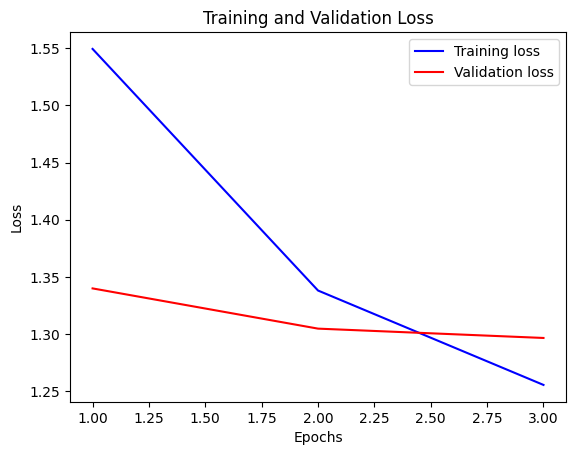

In [5]:
file_name = 'losses.pkl'
with open(file_name, 'rb') as f:
    data = pickle.load(f)

losses_train = data['losses_train']
losses_test = data['losses_test']

# Step 2: Plot the data
epochs = range(1, len(losses_train) + 1)  # Assuming losses_train and losses_test have the same length

plt.plot(epochs, losses_train, 'b', label='Training loss')
plt.plot(epochs, losses_test, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

pipe = pipeline(task="fill-mask", model="./test_model")

In [22]:
model=AutoModelForMaskedLM.from_pretrained("./test_model")
model=model.to(device)

In [115]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_python-finetuned-imdb/checkpoint-920384")
model_hugging_face=model_hugging_face.to(device)

In [10]:
model_kb=AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
correct_predictions = 0
total_predictions =0
model.eval()
device="cpu"
for step,batch in enumerate(train_dataloader):
    batch["input_ids"] = batch["input_ids"].to(device)
    batch["attention_mask"] = batch["attention_mask"].to(device)
    batch["labels"]= batch["labels"].to(device)
    indices_tokens_masked = []
    for labels in batch["labels"]:
        indices_tokens_masked.append(torch.nonzero(labels !=-100).flatten().tolist())
    output=model_kb(**batch)
    print(output.loss)
    predicted_token_ids = torch.argmax(output.logits,dim=-1)
    print(predicted_token_ids)

    for i in range(len(indices_tokens_masked)):
        for j in indices_tokens_masked[i]:
            total_predictions +=1
            if batch["labels"][i][j] == predicted_token_ids[i][j]:
                correct_predictions += 1

     # Créer un masque pour filtrer les étiquettes
    mask = (batch["labels"] != -100)

    # Appliquer le masque pour obtenir les prédictions et les étiquettes filtrées
    filtered_preds = predicted_token_ids[mask]
    filtered_labels = batch["labels"][mask]

    # Calculer et afficher l'accuracy
    batch_acc = torch.mean((filtered_preds == filtered_labels).float())
    print("Batch Accuracy:", batch_acc.item())
    break

print("acuraccy :",correct_predictions/total_predictions)
        



tensor(8.2863, grad_fn=<NllLossBackward0>)
tensor([[    7,   109,   252,  ...,  3116,     7, 21264],
        [    7, 49686,    19,  ..., 38858,   145, 17675],
        [    7,  7414, 13048,  ...,  5847, 26006,   268],
        ...,
        [    7,     7, 33423,  ...,   126, 20035,  1057],
        [    7,   148,   512,  ...,  4838,  7541,     7],
        [   19,    98,    19,  ...,    52,     1,     7]])
Batch Accuracy: 0.19413287937641144
acuraccy : 0.19413287316652286


In [16]:
evaluation_task(model_hugging_face,eval_dataloader)

Trainer evaluation....


/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/11893 [00:00<?, ?it/s]

>>> Perplexity: 2.17
Manual perplexity...
 Perplexity: 2.1704916809154797
Accuracy...
Accuracy: 0.8261846081389651


In [ ]:
evaluation_task(model_kb,eval_dataloader)

In [ ]:
evaluation_task(model,eval_dataloader)

In [14]:
eval_dataloader_bis = preprocessing.create_dataloader(eval_dataset,1,default_data_collator)

In [27]:
model.eval()

losses=[]
for step, batch in enumerate(eval_dataloader_bis):
    batch={key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    loss = outputs.loss
    losses.append(loss.item())
   
    

Manual perplexity...


TypeError: expected Tensor as element 0 in argument 0, but got float

In [15]:
with open("kb_losses","rb") as f:
    losses = pickle.load(f)
print("Manual perplexity...")

high_loss_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)

print( high_loss_indices)


Manual perplexity...
[228949, 290102, 627791, 65913, 112858, 139837, 159417, 161681, 409293, 154350, 558595, 665401, 227891, 49837, 656234, 108311, 91149, 142690, 192936, 544218, 648376, 549398, 499645, 585144, 173356, 225262, 40200, 534674, 542773, 36212, 713826, 178000, 212050, 226122, 272475, 314044, 300341, 357848, 536451, 501358, 19950, 456140, 645318, 632232, 739899, 174101, 109590, 757573, 713759, 67814, 236838, 231013, 326169, 644288, 467425, 231629, 467143, 49948, 396677, 617259, 283326, 329026, 581819, 728617, 181269, 608531, 559600, 509610, 303478, 30149, 152630, 481409, 128456, 505194, 27517, 178354, 664772, 331248, 243670, 109917, 609698, 68811, 500924, 188354, 159796, 547396, 293892, 747556, 373469, 6973, 670079, 61920, 418802, 91089, 176398, 627822, 676039, 727243, 704174, 715473, 226145, 175872, 729375, 451133, 188223, 262079, 113845, 31965, 415545, 124233, 666605, 1435, 556064, 158244, 246734, 576553, 722601, 491865, 712408, 127062, 381202, 632033, 710940, 724217, 6225

In [17]:
for idx in high_loss_indices[:5]:
    input_ids = eval_dataset[idx]["input_ids"]

    labels = eval_dataset[idx]["labels"]
    masked_indices = (labels != -100)
    inputs_masked = [labels[i] for i in range(len(labels)) if labels[i]!=-100]
    decoded_text = tokenizer.decode(input_ids)
    decoded_masked_tokens = tokenizer.decode(inputs_masked)
    print("Original Text:", decoded_text)
    print("Masked Tokens:", decoded_masked_tokens)
    print("Loss:", losses[idx])
    

Original Text: ##lskantillandraspråk, fårjagsäga, attdåvinufåfrittvalavämnenpågymnasiet, ärdetlikastorautsikterförattengelskanund [MASK] [MASK]förhållandenkan [MASK]allaberättigadeanspråktillgodosedda — ävenpågymnasiet. Följaktligen, dåjagtänkerpåden4 - årigarealskolan, blirresultatetavutskottetsförslag, [MASK]de, somslutamedrealskolan, fåendasttreårs [MASK]iengelska, ochdåmaniallmänhetärbenägenfrån [MASK]hållattanse, attengelskandockärdet [MASK]igastespråketfrånpraktisksynpunkt, [MASK]jagredanfrån
Masked Tokens: ##erallafå att,undervisningallavikt måste
Loss: 17.215864181518555
Original Text: ##täramålsättninghållesklartisikte. Jaganserinteatt [MASK]föreliggernågothinderföratthemvärnet [MASK] idenmåndettaärmöjligt, påtagersigdennauppgift [MASK] Jagtrorattsamhälletmå lärandebästa [MASK]dessaövningargörasgemens radiop [MASK] Medhänsyn organiserade [MASK]påfrestningar, somvårtsamhällesäkertkommer Syrutsättasför [MASK]efterdennakrigskat [MASK], ochtilldenfulländning, [MASK]propagandaväsen

In [22]:
for step, batch in enumerate(eval_dataloader_bis):
    print(batch)
    break

{'input_ids': tensor([[15335,  2261,     4, 19862, 49795,     4, 32829, 12347,    11,  6929,
          3095, 48798,    19,  1616,     4,   929,   255,    19,    67, 25761,
          7981,   141,    35, 45138, 34186, 23370,     4,  8884,   260,     4,
         33514,  3559, 35880,   270,  5519,  2070,     5, 17785, 45138,   149,
          8519,  5245,     7,   160,  1379,    16,   454,     4, 49071,  8264,
            49,  2261,  1057, 33678,  2070, 41435,  1875,     4, 20296,   353,
           138,    19, 15287, 26928, 20651, 14270, 49797, 13687,     4, 49796,
            19,    67,     4, 46631, 12323,   562,     7, 41386,  2354,  7248,
           562,    19,  3822,   429,     4,    19, 39114, 35978,     4,    19,
            67, 28148,   210,    89,     4, 36767,   259,  1314, 25410, 41608,
         23858,  6441, 34582,   605,    19,     1,    19,     1,     7,  1478,
          4677, 24202,     4,  3101,   738,  6882,   493, 43177,    67,  2666,
         28886,  1457,   149,    44, 3

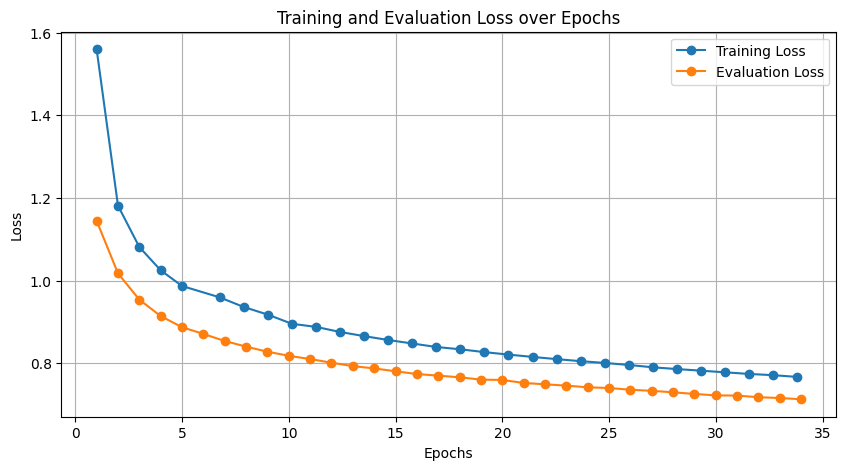

In [4]:


# Load data from Json file
with open('finetuning_hugging_python-finetuned-imdb/checkpoint-1955816/trainer_state.json', 'r') as file:
    data = json.load(file)

train_loss = []
eval_loss = []
epoch_train = []
epoch_test=[]

for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch_train, train_loss, label='Training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Evaluation Loss', marker='o')
plt.title('Training and Evaluation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Pseudo Log Likelyhood implementation (from "A Better way to do masked scoring")

In [11]:
pad_token_id= tokenizer.pad_token_id
sep_token_id = tokenizer.sep_token_id

In [63]:
max_length=128

In [112]:
def insert_special_masking_bis(batch, i):
    word_ids = batch["word_ids"]
    masked_input_id = batch["input_ids"].copy()
    attention_mask = batch["attention_mask"].copy()
    
    labels = np.full_like(masked_input_id, -100)
    
    for z, seq in enumerate(masked_input_id):
        if seq[i] == tokenizer.pad_token_id or seq[i] == tokenizer.sep_token_id:
            continue
        
        labels[z, i] = seq[i]
        masked_input_id[z][i] = tokenizer.mask_token_id
        future_token = [j for j, _ in enumerate(word_ids[z]) if word_ids[z][j] == word_ids[z][i] and j > i]
        
        for j in future_token:
            labels[z][j] = batch["input_ids"][z][j]
            masked_input_id[z][j] = tokenizer.mask_token_id
    
    return {
        "input_ids": masked_input_id,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [117]:
pll = 0
batch_size=64
for i in  range(max_length):
    losses=[]
    eval_dataset_log = lm_datasets["test"].map(
        lambda examples: insert_special_masking_bis(examples,i),
        batched=True,
        remove_columns= lm_datasets["test"].column_names
    )
    eval_dataloader = preprocessing.create_dataloader(eval_dataset_log,batch_size,default_data_collator)
    for step, batch in enumerate(eval_dataloader):
        batch={key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            output=model_hugging_face(**batch)
        loss=output.loss
        losses.append(loss.repeat(eval_dataloader.batch_size))
    losses = torch.cat(losses)
    losses = losses[: len(eval_dataloader.dataset)]
    pll += torch.mean(losses)


pll /=max_length
pll

In [66]:
i=50

eval_datset_log = eval_dataset.map(
    lambda examples: insert_random_mask(examples,data_collator),
    batched=True,
    remove_columns=eval_dataset.column_names,
)
   
eval_datset_log

Map:   0%|          | 0/761125 [00:00<?, ? examples/s]

tensor([[    2,   219,  5751,  ...,    19,     4,    19],
        [  275,  8414,     4,  ...,    19,    82,     4],
        [  629,  3010,     4,  ..., 15104, 34954,    32],
        ...,
        [   19,   100,   175,  ...,   226, 26310,    19],
        [   21, 10996,   756,  ..., 49795,     7, 43524],
        [33261,     4, 49806,  ..., 45477,   506, 23858]])
<class 'numpy.ndarray'>
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
<class 'numpy.ndarray'>
tensor([[ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  1057,  ...,  -100,  -100,  -100],
        ...,
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100, 49808,  -100,  ...,  -100,  -100,  -100]])
<class 'nu

KeyboardInterrupt: 